# Photometry Homework

Obs Tech - Homework 2
21 October 2020
Due: Thursday (November 5)


The primary goal of this homework is for the student to become familiar with the tools for photometry that will be needed for their class project. 

Median combine darks for each exposure time
This creates the Master Dark for each exposure time
Median combine flat images for each filter
Subtract the appropriate Master Dark from the appropriate Combined Flat Image for each filter
To create the Master Flat
(master_flat = combined_flat-Dark / np.median(combined_flat)
Take the individual science frames and subtract the appropriate master dark
Divide by the master flat
Align the images using np.roll on the array
Now when they are aligned, median combine them to create master science 

In [1]:
from astropy.io import fits
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

## Select data
For this exercise, we will use RHO 14-inch data taken last week on the open cluster h Per.

Inspect the images, and make sure that the data looks OK. 

In [2]:
darks_filenames = glob('2020-10-17/h_persei_darks*')
darks = []
darks_filters = []

for i in range(len(darks_filenames[1:])):
    darks.append(fits.getdata(darks_filenames[i]))
    hdul = fits.open(darks_filenames[i])
    darks_filters.append(hdul[0].header['FILTER'])
    hdul.close()
    
darks = np.asarray(darks)
darks = darks.astype(float)
darks.shape

(9, 1266, 1676)

In [3]:
flats_filenames = glob('2020-10-17/h_persei_flats*')
flats = []
flats_filters = []

for i in range(len(flats_filenames[1:])):
    flats.append(fits.getdata(flats_filenames[i]))
    hdul = fits.open(flats_filenames[i])
    flats_filters.append(hdul[0].header['FILTER'])
    hdul.close()
    

flats_filters = np.asarray(flats_filters)
flats = np.asarray(flats)
flats = flats.astype(float)

R_flats = flats[np.where(flats_filters == 'R')]
V_flats = flats[np.where(flats_filters == 'V')]
B_flats = flats[np.where(flats_filters == 'B')]
I_flats = flats[np.where(flats_filters == 'I')]

In [4]:
seq_filenames = np.sort(glob('2020-10-17/h_persei_seq*'))
seq_light = []
seq_dark = []
seq_filters = []

for i in range(len(seq_filenames[1:])):
        
    hdul = fits.open(seq_filenames[i])
    if hdul[0].header['FRAME'] == 'Light':
        seq_filters.append(hdul[0].header['FILTER'])
        seq_light.append(fits.getdata(seq_filenames[i]))
    else:
        seq_dark.append(fits.getdata(seq_filenames[i]))
    hdul.close()

seq_filters = np.asarray(seq_filters)
seq_light = np.asarray(seq_light)
seq_light = seq_light.astype(float)


R_seq = seq_light[np.where(seq_filters == 'R')]
V_seq = seq_light[np.where(seq_filters == 'V')]
B_seq = seq_light[np.where(seq_filters == 'B')]
I_seq = seq_light[np.where(seq_filters == 'I')]

### Master Dark:

In [5]:
master_V_dark = np.median(seq_dark, axis=0)

### Master Flat:

In [6]:
comb_V_flat = np.median(V_flats,axis=0) - master_V_dark
div = master_V_dark/np.median(comb_V_flat)
master_V_flat = comb_V_flat - div

### Subtract dark and divide by flat for each science frame

In [7]:
V_proc = []

for i in range(len(V_seq)):
    V_proc_temp = V_seq[i] - master_V_dark
    V_proc.append(V_proc_temp/master_V_flat)

### Shifting frames

In [8]:
V1 = V_seq[0]
V2 = np.roll(V_proc[1], [0,4], axis=(0,1))
V3 = np.roll(V_proc[2], [0,7], axis=(0,1))
V4 = np.roll(V_proc[3], [0,7], axis=(0,1))
V5 = np.roll(V_proc[4], [-1,8], axis=(0,1))
V6 = np.roll(V_proc[5], [-2,7], axis=(0,1))
V7 = np.roll(V_proc[6], [-3,5], axis=(0,1))
V8 = np.roll(V_proc[7], [-6,3], axis=(0,1))
V9 = np.roll(V_proc[8], [-8,2], axis=(0,1))
V10 = np.roll(V_proc[9], [-10,-1], axis=(0,1))

V = [V1, V2, V3, V4, V5, V6, V7, V8, V9, V10]
V = np.asarray(V)
V = np.median(V, axis=0)

## PSF characteristics
Use the image in one band you have selected to measure the typical FWHM (in pixels) of the stars in the field.  You should check several stars (3-5).  They should be isolated and relatively bright, but be sure to avoid saturated stars.  Record the FWHM values.

In [9]:
from astropy.modeling import models, fitting

In [10]:
# Cut out smaller box around PSF
def cutout(image, bb, center):
    xc = int(center[0])
    yc = int(center[1])
    box = image[yc-bb:yc+bb, xc-bb:xc+bb]
    xp, yp = box.shape
    return xp, yp, box

In [11]:
Vf = np.flip(V, 0)

In [15]:
def gaussian(yp, xp, box):
    # Generate grid of same size like box to put the fit on
    y, x, = np.mgrid[:yp, :xp]
    # Declare what function you want to fit to your data
    f_init = models.Gaussian2D()
    # Declare what fitting function you want to use
    fit_f = fitting.LevMarLSQFitter()
    
    # Fit the model to your data (box)
    fV = fit_f(f_init, x, y, box)
    
    return fV, x, y

In [17]:
def sigma_avg(x,y):
    return np.mean([float(x), float(y)])

# Identify the stars you're looking at

By comparing the images to some online catalog image server, you should be able to identify some of the stars. Use the known RA,Dec of these stars to estimate the pixel scale (arcsec/pix) of the image. Then convert the measured FWHM in pixels to FWHM in arcsec,

In [18]:
def px_to_arcsec(fwhm):
    return fwhm*0.605

## 0.605 arcsec/pixel ##

http://nova.astrometry.net/user_images/4117481#annotated

In [184]:
def psf(image, targ_loc, boxsize, plot='star'): 
    #center = max of Gaussian fit
    #1. We have the approx. location of each star.
    #2. Cut out a square that's +/- 15 pixels from that location
    
    #4. We fit a gaussian to that thing (above)
    #5. Find the pixel location of the max of gaussian - this is the center of the PSF
    #6. Calculate 1.3#FWHM
    #7. Go thru each pixel in the "small cutout" square: if it lies outisde of ^ distance, out
    #8. Raw intensity = # of counts added up in there. N_targ = # of fixels in there.
    #9. Get the donut between 2 and 3 FWHM
    #10. Subtract 8-median(9)*N_targ
    #11. Convert to instrumental magnitudes.
    # pixel = go through all pixels. 2 for loops (rip computer time)
    
    ######## STEP 2 #########
    F_sky_pix = []
    
    targ_loc[1] = 1266-targ_loc[1]
    
    xp, yp, current_image = cutout(image, boxsize, targ_loc)
    
    ######## STEP 4 #########
    fV, x, y = gaussian(xp, yp, current_image)
    
    if plot=='star':
        plt.imshow(current_image)
        plt.show()
    elif plot =='gaussian':
        plt.imshow(fV(x,y))
        plt.show()
    
    sigma = sigma_avg(fV.x_stddev[0],fV.y_stddev[0])
    #xbar = fV.x_mean[0]
    fwhm = 2.355*float(sigma)
    fit = fV(x, y)
    
    center = np.where(fit == np.max(fit))
 
    ######## STEP 7 #########
    circ_image = np.zeros(current_image.shape)
    N_targ = 0
    for i in range(len(current_image)):
        for j in range(len(current_image[0])):
            dist = np.sqrt((center[0]-i)**2+(center[1]-j)**2)
            if dist >= 2*fwhm and dist <= 3*fwhm:
                F_sky_pix.append(current_image[i][j])  
            if (dist > 1.3*fwhm):
                circ_image[i][j] = 0.0 # this is the same cutout image but with all values outside of the radius set to NaN
            else:
                circ_image[i][j] = current_image[i][j]
                N_targ+=1 # total number of pixels in the 1.3*fwhm

    ######## STEP 8 #########
    F_sky_pix_med = np.median(F_sky_pix)
    F_targ_raw = 0
    F_targ_raw = np.sum(circ_image)
    
    if plot=='cutout':
        plt.imshow(circ_image)
        plt.show()
    

    ######## STEP 10 #########
    F_targ = F_targ_raw - N_targ*F_sky_pix_med
    F_targ_pers = F_targ/5. #ADU/s
                        
    return F_targ, F_targ_pers
    
    

In [185]:
#targlocs = [[440, 135], [382,1013], [529,634], [892, 1139]]
#boxsizes = [25, 35, 55, 55]

Location:  [10, 1028]   Boxsize:  25
Location:  [440, 134]   Boxsize:  25


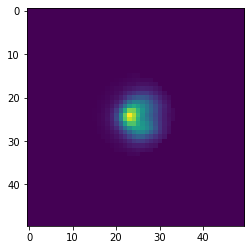

35.7872215312981 7.15744430625962
Location:  [382, 1013]   Boxsize:  35


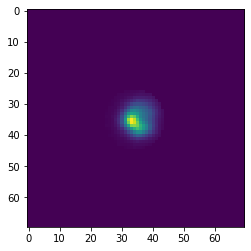

14.38235765993272 2.876471531986544
Location:  [529, 634]   Boxsize:  55


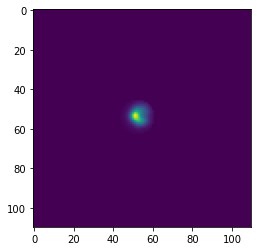

11.497039081072556 2.299407816214511
Location:  [892, 1139]   Boxsize:  55


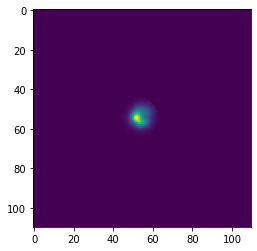

10.01121923897554 2.002243847795108
Location:  [334, 462]   Boxsize:  45


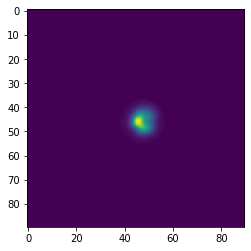

11.338910621351555 2.267782124270311
Location:  [506, 139]   Boxsize:  35


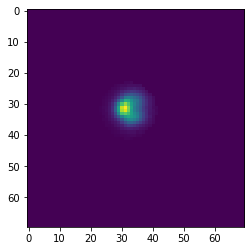

12.97958830751144 2.595917661502288
Location:  [1094, 1129]   Boxsize:  55


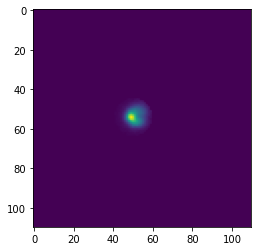

6.862088983036446 1.3724177966072892
Location:  [1159, 529]   Boxsize:  35


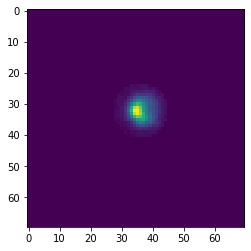

2.1389255244893364 0.42778510489786725
Location:  [554, 1034]   Boxsize:  40


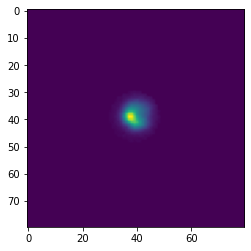

4.145188203672612 0.8290376407345225
Location:  [194, 272]   Boxsize:  36


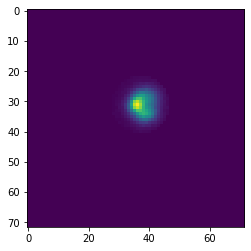

6.2187581446074045 1.243751628921481
Location:  [467, 851]   Boxsize:  20


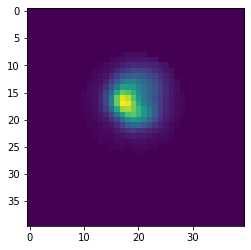

6.331687912182897 1.2663375824365795
Location:  [329, 956]   Boxsize:  25


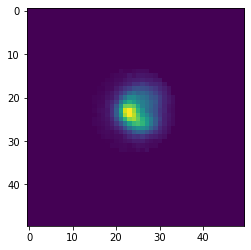

4.025998749365607 0.8051997498731215
Location:  [136, 314]   Boxsize:  25


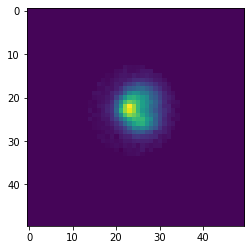

2.460634318754287 0.49212686375085746
Location:  [314, 340]   Boxsize:  25


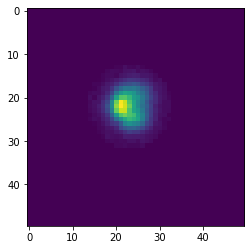

2.9509034890641006 0.5901806978128201
Location:  [318, 394]   Boxsize:  25


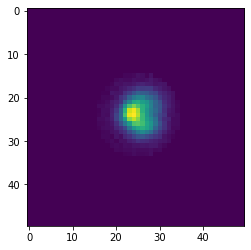

2.6303523402854494 0.5260704680570899
Location:  [719, 199]   Boxsize:  35


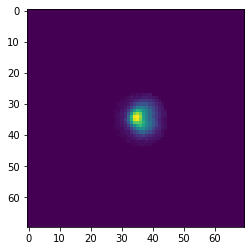

2.9473356583584787 0.5894671316716957
Location:  [797, 458]   Boxsize:  40


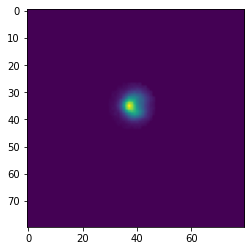

3.855444243560285 0.7710888487120571
Location:  [1159, 529]   Boxsize:  35


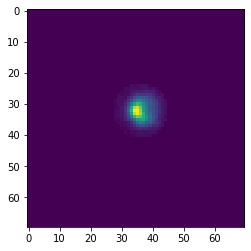

2.1389255244893364 0.42778510489786725
Location:  [966, 936]   Boxsize:  25


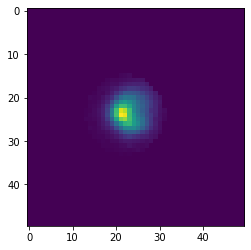

4.736179392729666 0.9472358785459332


In [190]:
targlocs = [[106, 1034], [536,140], [478, 1019], [625, 640], [988, 1145], [430, 468], [602, 145], [1190,1135], [1255, 535], [650, 1040], [290, 278], [563, 857], [425, 962], [232,320], [410,346], [414,400], [815,205], [893,464], [1255,535], [1062,942]]
boxsizes = [25, 25, 35, 55, 55, 45, 35, 55, 35, 40, 36, 20, 25, 25, 25, 25, 35, 40, 35, 25]


for i in range(len(targlocs)):
    for j in range(len(targlocs[0])):
        if j==0:
            targlocs[i][j] = targlocs[i][j] - 96
        elif j==1:
            targlocs[i][j] = targlocs[i][j] - 6


for i in range(len(targlocs)):
    print('Location: ', targlocs[i], '  Boxsize: ', boxsizes[i])
    try:
        F_targ, F_targ_pers = psf(Vf, targlocs[i], boxsizes[i], plot='cutout')
        print(F_targ, F_targ_pers)
    except TypeError:
        pass
    except ValueError:
        pass

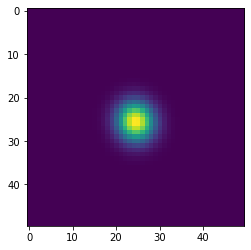

(35.7872215312981, 7.15744430625962)

In [88]:
psf(Vf, [440,135], 25)

10.941713886690774


(10.527697593042124, 2.105539518608425)

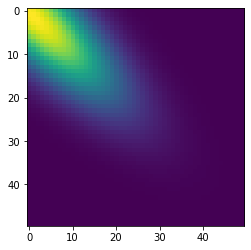

In [21]:
psf(Vf, [382,1013])

13.451890811545448


/Users/nbudaiev/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/nbudaiev/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(nan, nan)

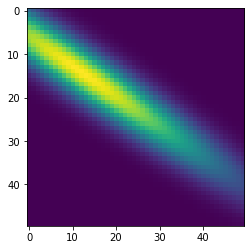

In [22]:
psf(Vf, [529,634])

11.505180453597362


(nan, nan)

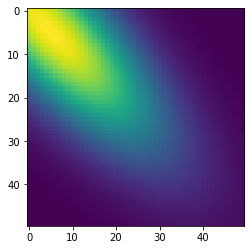

In [23]:
psf(Vf, [892,1139])

In [31]:
#m_i = -2.5 * log(F)

In [32]:
For a standard star:

SyntaxError: invalid syntax (<ipython-input-32-9bd461b91ae5>, line 1)

In [33]:
dm = m_cat(std) = m_i(std)

SyntaxError: cannot assign to function call (<ipython-input-33-d4969ba6d96d>, line 1)

In [ ]:
for target, m_obs = m_i(targ) + dm

## PSF-Fitting Photometry
#### This is an OPTIONAL "bonus round" to Homework 2 - no points deducted if you skip it.

Try using a PSF-fitting program such as DAOPhot to do the photometry of the same 10 stars.  How well does it compare to the catalog photometry?